#Robustness and Adversarial Testing Exercise

### Purpose:
This exercise is designed to help students explore the effects of small changes in input data on a pre-trained image classification model. Students will learn to generate adversarial examples and analyze model robustness by filling in the blanks in the code

### Objective
- Load a pre-trained image classification model
- Apply perturbations to generate adversarial examples
- Compare the model's predictions on the original and perturbed images
- Analyze the robustness of the model based on its peformance on adversarial examples

## Step 0: Setup
Before proceeding, we need to install and import the necessary libraries. Foolbox will help us generate adversarial examples, TensorFlow provides the pre-trained model, and Matplotlib will visualize the results.

In [ ]:
# Install the required libraries
!pip install foolbox tensorflow matplotlib

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import foolbox as fb
from foolbox import TensorFlowModel, criteria
from foolbox.criteria import Misclassification
from foolbox.attacks import LinfPGD
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from PIL import Image
import eagerpy as ep

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00


## Step 1: Load a Pre-Trained Model
We will use the MobileNetV2 model, pre-trained on ImageNet, for this exercise

In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
model = MobileNetV2(weights="imagenet")

# Wrap the TensorFlow model for Foolbox compatibility
model = fb.TensorFlowModel(model, bounds=(0, 255))

# Confirm model loading
print("Model Loaded: MobileNetV2")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Model Loaded: MobileNetV2


## Step 2: Load and Preprocess an Image
In this step, we load an example image, preprocess it, and make predictions using the MobileNetV2 model.

187953/187953 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


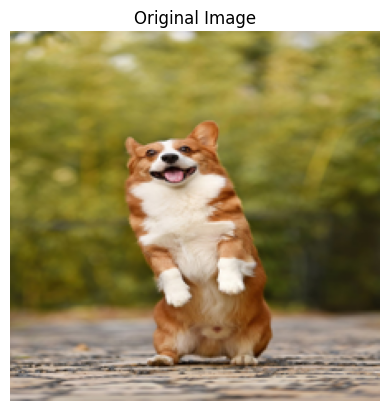

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original Predictions:
Pembroke: 84.60%
Cardigan: 9.92%
Welsh_springer_spaniel: 0.48%


In [ ]:
# Download an example image (dog) and load it
img_path = tf.keras.utils.get_file(
    'dog.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Fawn_and_white_Welsh_Corgi_puppy_standing_on_rear_legs_and_sticking_out_the_tongue.jpg/1024px-Fawn_and_white_Welsh_Corgi_puppy_standing_on_rear_legs_and_sticking_out_the_tongue.jpg'
)
img = Image.open(img_path).resize((224, 224)) # Resize the image to 224x224 as required by MobileNetV2
img_array = np.array(img) # Convert the image to a NumPy array

# Preprocess the image for the model
input_image = preprocess_input(np.expand_dims(img_array, axis=0))

# Display the original image
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Predict the label for the original image
original_predictions = model(input_image)

# Decode the top-3 predictions
decoded_preds = decode_predictions(original_predictions, top=3)[0]
print("Original Predictions:")
for pred in decoded_preds:
  print(f"{pred[1]}: {pred[2]*100:.2f}%")

## Step 3: Generate Adversarial Examples Using Foolbox
Adversarial examples will be created using Foolbox's Fast Gradient Sign Method (FGSM).

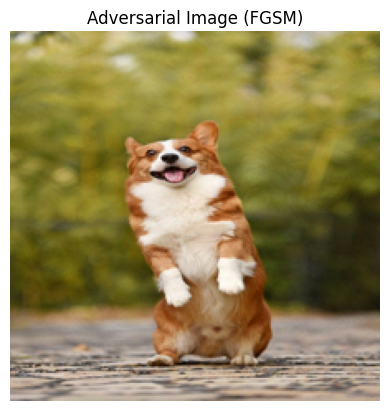

Adversarial Predictions:
Cardigan: 28.93%
Welsh_springer_spaniel: 14.60%
Border_collie: 8.75%


In [ ]:
# Wrap the model for Foolbox compatibility
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Define the FGSM attack
attack = fb.attacks.FGSM()

# Define the attack criterion (e.g., Misclassification) by pulling the predicted label of the original image
criterion = fb.criteria.Misclassification(labels=np.array([np.argmax(original_predictions)]))

# Generate adversarial example
adversarial_image = attack(
    fmodel,
    tf.convert_to_tensor(input_image),
    criterion,
    epsilons=0.01  # Perturbation size
)

# Clip and scale adversarial image for visualization
adversarial_image_clipped = np.clip(
    ((adversarial_image[0].numpy() + 1) * 127.5), 0, 255
).astype(np.uint8)

# Display the adversarial image
plt.imshow(adversarial_image_clipped[0])
plt.title("Adversarial Image (FGSM)")
plt.axis("off")
plt.show()

# Preprocess the adversarial image for prediction
adversarial_input_image = preprocess_input(np.expand_dims(adversarial_image_clipped[0], axis=0))

# Predict the label for the adversarial image
adversarial_predictions = model(adversarial_input_image)

# Decode the top-3 prediction for the adversarial image
decoded_adversarial_preds = decode_predictions(adversarial_predictions, top=3)[0]
print("Adversarial Predictions:")
for pred in decoded_adversarial_preds:
  print(f"{pred[1]}: {pred[2]*100:.2f}%")

## Step 4: Compare Results
Analyze and compare the predictions for the original and adversarial images.

In [ ]:
# Compare the predictiosn for the original and adversarial images
print("\nComparison:")
print("Original Predictions:")
for pred in decoded_preds:
  print(f"{pred[1]}: {pred[2]*100:.2f}%")

print("\nAdversarial Predictions:")
for pred in decoded_adversarial_preds:
  print(f"{pred[1]}: {pred[2]*100:.2f}%")


Comparison:
Original Predictions:
Pembroke: 84.60%
Cardigan: 9.92%
Welsh_springer_spaniel: 0.48%

Adversarial Predictions:
Cardigan: 28.93%
Welsh_springer_spaniel: 14.60%
Border_collie: 8.75%


## Conclusion
Discuss your findings:
1. How did the predictions change between the original and adversarial images?
2. Was the model fooled by the adversarial example?
3. What do these results tell you about the robustness of MobileNetV2?